# <center> Автоэнкодеры (AE) и Вариационные автоэнкодеры (VAE) в RecSys </center> 

In [53]:
import warnings
warnings.filterwarnings('ignore')

import bottleneck as bn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import random
import pandas as pd
import seaborn as sn
import shutil
import sys
import tensorflow.compat.v1 as tf
import torch
tf.disable_v2_behavior()
sn.set()

from scipy import sparse

Отступление в виде статьи, которое даст обоснование, почему мы будем рассматривать именно Mult-VAE и Mult-DAE для RecSys из большого множества методов. 

**Ferrari Dacrema, M., Cremonesi, P. and Jannach, D., 2019, September. Are we really making much progress? A worrying analysis of recent neural recommendation approaches. In Proceedings of the 13th ACM conference on recommender systems (pp. 101-109).**

Статья: https://arxiv.org/pdf/1907.06902.pdf 

Код: https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation?utm_source=catalyzex.com 



Check-list:
<br>
<br>
<div>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Доступность source code для модели и экспериментов</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Наличие перебора гиперпараметров новой предлагаемой модели</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Наличие перебора гиперпараметров выбранных бейзлайнов</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Наличие простых бейзлайнов</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Наличие бейзлайнов из разных семейств алгоритмов</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Отсутствие обоснования sota через новизку NN подхода</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Описание неудачных экспериментов (проблема выжившего) </label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Использование открытых датасетов </label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Использование схожего/одинакового препроцессинга с бейзлайнами и/или подробное описание</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Использование схожего/одинакового evaluation с бейзлайнами и/или подробное описание</label> <br>
  <input type="checkbox" name="uchk" checked>
  <label for="uchk">Использование одинаковых метрик качества и списка k с теми, что в бейзлайнах</label> <br>
</div>

Что можно еще добавить? 

В частности, не забыть фиксировать сиды для воспроизводимости результатов. Например, так:

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

Mult-VAE - оказалась чуть ли не единственной моделью, которая смогла подтвердить свои результаты при воспроизведении н не проиграть простым бейзлайнам. 

Давайте вспомним, что такое автоэнкодеры, и обсудим, почему они применимы и эффективны в RecSys?

**Autoencoders (AE)**

- В чем основная идея подхода? А для RecSys?
- Какую функцию потерь минимизируем? Что такое ELBO? 

<img src='./images/AE.png' width=400>

**Variational Autoencoder (VAE)**

- В Чем принципиальное отличие от AE?

<img src='./images/VAE.png' width=400>

- Чем полезна предпосылка о ст.норм.распределении?
<img src='./images/2d.png' width=400>
<img src='./images/bell.png' width=400>

\+ волшебная формулка $z = \mu + \sigma \cdot \epsilon$, где $\sigma^2 =(\sigma^2_1, \sigma^2_2)$, и $\epsilon \sim N (0, 1)$ для VAE.

**Достоинства VAE:**

+ Одновременно тренируем способность нейросети реконструировать исходные данные и генерировать новые из аппроксимированного распределения. 
* Из стандартного нормального распределения проще сэмплировать, чем у обычного автоэнкодера. 
* ?

**Недостатки VAE:**
- Есть ли склонность к переобучению?

\+ есть еще **Denoising Autoencoder (DAE)**

<img src='./images/compare.png' width=600> 

Вспомнили! Теперь к RecSys адаптациям и особенностям.

**Mult-VAE** - обобщение вариационного автоэнкодера для коллаборативной фильтрации. 

**Liang, D., Krishnan, R.G., Hoffman, M.D. and Jebara, T., 2018, April. Variational autoencoders for collaborative filtering. In Proceedings of the 2018 world wide web conference (pp. 689-698).**

Статья: https://arxiv.org/pdf/1802.05814.pdf 

Формализация из статьи:



$u \in \{1,\dots,U\}$ - пользователи, 

$i \in \{1,\dots,I\}$ - объекты (айтемы),

$\mathbf{X} \in \mathbb{N}^{U\times I}$ - матрица интеракций из кликов в бинарном виде. 

$$\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$$ - вектор из мешка слов по айтемам с числом кликов пользователя по каждому из них. 

Функция потерь для Mult-VAE для каждого пользователя $u$:

$$\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))$$

где $q_\phi$ - аппроксимирующее вариационное распределение (inference модель), $\beta$ - доп. параметр имитации отжига. 

Целевая функция для всего датасета - усреднение по пользователям. 


Генеративный процесс: Для каждого пользователя $u$, модель сэмплирует $K$-размерный латентный вектор  $\mathbf{z}_u$ из стаднтарного нормального распределения. Вектор $\mathbf{z}_u$ преобразуется нелинейной функцией $f_\theta (\cdot) \in \mathbb{R}^I$, чтобы получить вероятностное распределение по всем $I$ айтемам $\pi (\mathbf{z}_u)$ на основе имевшегося $\mathbf{x}_u$.
$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) \propto \exp\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

Целевая функция для Multi-DAE для каждого пользователя $u$:
$$
\mathcal{L}_u(\theta, \phi) = \log p_\theta(\mathbf{x}_u | g_\phi(\mathbf{x}_u))
$$
где $g_\phi(\cdot)$ - нелинейная "encoder" функция.


Возьмем любимый датасет Movielens-20M. 

In [5]:
DATA_DIR = '.'
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

В статье делалаи следующий препроцессинг:
- Модель авторов обучается на бинарных данных, поэтому нужно задать порог для оценок, выше которого считаем за 1.
- Разбить пользователей на training/validation/test. Обучаться будем на полной истории кликов пользователей из train, а предсказываться на новых пользователях, что часто приближено к реальным условиям индустриальных датасетов, хотя тоже есть свои ремарки. 
- Среди отложенных пользователей, 80% кликов оставить на train и 20% - на подсчет метрик качества. 

In [6]:
raw_data = raw_data[raw_data['rating'] > 3.5]
raw_data.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
6,1,1287,5,978302039
7,1,2804,5,978300719


In [7]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [8]:
def filter_triplets(tp, min_uc=0, min_sc=0): 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [9]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

Мы запустим без фильтров, но попробуйте с ними, чтобы понять, повлияет ли это на качество в лучшую сторону.

In [10]:
sparsity = raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("В датасете %d интеракций от %d пользователей и всего по %d фильмов (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

В датасете 575281 интеракций от 6038 пользователей и всего по 3533 фильмов (sparsity: 2.697%)


Сделаем train/test/val сплит

In [11]:
unique_uid = user_activity.index

np.random.seed(42)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
n_users = unique_uid.size
n_heldout_users = 500

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]
unique_sid = pd.unique(train_plays['movieId'])

И encoder каким-нибудь другим способом, которым еще не делали, для разнообраия). Например, простой словарь.

In [12]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [13]:
pro_dir = os.path.join(DATA_DIR, '.')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [14]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(42)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 999 == 0 and i != 0:
            print(f"{i+1} users sampled")
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

Валидационная выборка

In [15]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)
vad_plays_tr.shape, vad_plays_te.shape

((36293, 4), (8810, 4))

Тестовая выборка

In [16]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)
test_plays_tr.shape, test_plays_te.shape

assert vad_plays_tr.userId.nunique() == test_plays_tr.userId.nunique()

Сохраним (user_id, item_id) формат данных для модели

In [17]:
def numerize(df, filename):
    df.userId = df.userId.map(profile2id)
    df.movieId = df.movieId.map(show2id)
    df.rename(columns={'userId': 'uid', 'movieId': 'sid'}, inplace=True)
    df.dropna(inplace=True)
    df[['uid', 'sid']].to_csv(os.path.join(pro_dir, filename), index=False)

In [18]:
train_data = numerize(train_plays, 'train.csv')
vad_data_tr = numerize(vad_plays_tr, 'validation_tr.csv')
vad_data_te = numerize(vad_plays_te, 'validation_te.csv')
test_data_tr = numerize(test_plays_tr, 'test_tr.csv')
test_data_te = numerize(test_plays_te, 'test_te.csv')

In [31]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # try to apply l2 regularization to weights
        # YOUR CODE HERE
        # multiply 2 so that it is back in the same scale
        loss = neg_ll #+ 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
        
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):      
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.initializers.glorot_uniform()))
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

In [32]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply l2 regularization to weights
        # YOUR CODE HERE
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL #+ 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # set mean and variance
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.initializers.glorot_uniform()))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.initializers.glorot_uniform()))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

### Загрузим выборку

In [21]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [22]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp[f'uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [23]:
pro_dir = '.'
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [24]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [25]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

Зададим гиперпараметры

In [26]:
N = train_data.shape[0]
idxlist = range(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [27]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [28]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

### Обучить Multi-VAE

Для набора данных ML-20M установили как генеративную функцию $f_\theta(\cdot)$, так и inference модель $g_\phi(\cdot)$ как трехслойный многослойный персептрон (MLP) с симметричной архитектурой энкодера и декодера.

Пример: Пример: генерирующая функция с размерностями [200 -> 600 -> n_items] MLP, что означает, что функция инференса бует [n_items -> 600 -> 200] MLP. Таким образом, общая архитектура Multi-VAE такова: [n_items -> 600 -> 200 -> 600 -> n_items].

In [39]:
p_dims = [200, 600, n_items]
n_epochs = 20

In [40]:
tf.reset_default_graph()
# tf.compat.v1.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [41]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [42]:
log_dir = './log/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ./log/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [43]:
chkpt_dir = './chkpt/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./chkpt/VAE_anneal200.0K_cap2.0E-01/I-600-200-600-I


In [44]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    N = train_data.shape[0]
    idxlist = list(range(N))
    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # val NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # исключить примеры из val и test (если есть)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # обновить лучшую модель
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

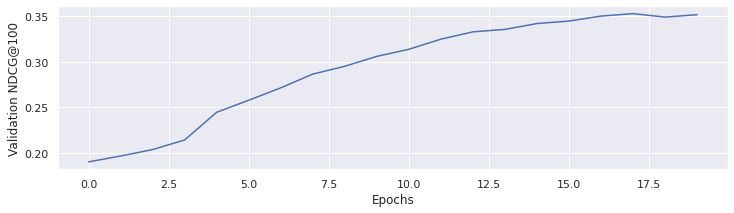

In [45]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs");

### Обучить Mult-DAE

In [46]:
p_dims = [200, n_items]
n_epochs = 20

In [47]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [48]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))

In [49]:
log_dir = './log/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ./log/DAE/I-200-I


In [50]:
chkpt_dir = './chkpt/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ./chkpt/DAE/I-200-I


In [51]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
                    
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)


        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

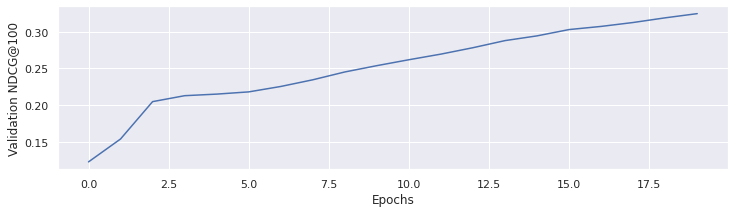

In [52]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs");

**Достоинства Mult-VAE:**

 ?
 
 
 **Недостатки Mult-VAE:**

 ?
 
**Отдельно - если сравнивать Mult-VAE vs. Mult-DAE**:

? 
